In [10]:
import numpy as np
import pandas as pd
import sklearn as sk
import json
import os

from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [135]:
# blow out the bbox into max.min values
def expand_bbox_coords(bbox):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[0] + bbox[2]
    ymax = bbox[1] + bbox[3]

    return (xmin, ymin, xmax, ymax)


def obtain_bbox_label(categories, bbox_tag):
    
    label = categories[categories['id']==bbox_tag['category_id']]['name'].item()
    label = str(label)

    return (label)

In [107]:
# load the annotation set
data = json.load(open('data/Label_Studio_Output/result.json'))

# convert annotated images json to dataframe to make slicing easier
images = pd.DataFrame(data['images'])

# convert annotated labels json to dataframe to make slicing easier
annots = pd.DataFrame(data['annotations'])
annots[['xmin', 'ymin', 'xmax', 'ymax']] = annots.apply(lambda x: expand_bbox_coords(x['bbox']), axis=1, result_type='expand')

# convert annotated images json to dataframe to make slicing easier
labels = pd.DataFrame(data['categories'])

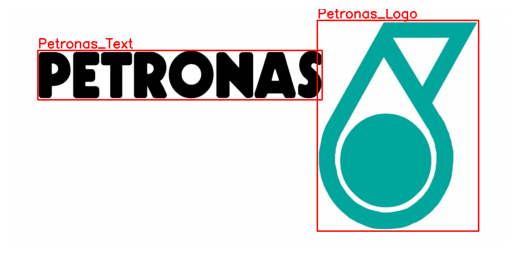

In [138]:
# print a test annotation
img_id = 0

# take the entry for the relevant image id
test_img = images[images['id']==img_id]

# load image
path = f"data/Label_Studio_Output/images/{os.path.basename(test_img['file_name'][0])}"
image = cv2.imread(path)

# ensure we are using the correct colour spectrum when displaying
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# overlay relevant bounding boxes
relevant_annots = annots[annots['image_id']==img_id]
for index, tag in relevant_annots.iterrows():
    # display bbox
    cv2.rectangle(
            image, 
            (int(tag.xmin), int(tag.ymin)), (int(tag.xmax), int(tag.ymax)),
            (255, 0, 0), 2
        )
    
    # display text label
    text = obtain_bbox_label(labels, tag)
    cv2.putText(
        image, text, (tag.xmin, tag.ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
        (255,0,0), 2
        )

# display
plt.imshow(image)
plt.axis('off')
plt.show()